# Tutorial: Class Activation Maps for Semantic Segmentation
![image.png](https://raw.githubusercontent.com/jacobgil/pytorch-grad-cam/master/examples/cars_segmentation.png)

In this tutorial we're going to see how to apply Class Activation Maps for semantic segmentaiton, using deeplabv3_resnet50 from torchvision.

For classification the model predicts a list of the scores per category.
For Semantic Segmentation models, the model predicts these scores for every pixel in the image.

We need to compute the Class Activation MAP with respect to some target.
Usually the target to maximize the score of one of the categories.

For segmentation, we have more choice in this target since we have a spatial dimention in the output as well.
Some options, proposed by https://arxiv.org/abs/2002.11434 , are:
1. Looking at one of the pixels
2. Looking at all of the pixels from one of the cateogiries.

We're going to use the second option, as an example.

Getting this to work will require us to:
1. Define a model wrapper to get the output tensor, since the pytorch model outputs a custom dictionary.
2. Define a target class for semantic segmentaiton.


In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import cv2 as cv
import requests
import torchvision
from PIL import Image
import matplotlib.pyplot as plt
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image 
from pytorch_grad_cam import GradCAM

from networks.vit_seg_modeling import ForensicTransformer as ViT_seg
from networks.vit_seg_modeling import CONFIGS as CONFIGS_ViT_seg

# Taken from the torchvision tutorial
# https://pytorch.org/vision/stable/auto_examples/plot_visualization_utils.html


In [2]:
#generate model
config_vit = CONFIGS_ViT_seg['R50-ViT-B_16']
config_vit.n_classes = 1
config_vit.n_skip = 3
config_vit.patches.size = (16, 16)
config_vit.patches.grid = (16,16)
# CNN feature as transformer input set (3,3), 
#filter feautre as transformer input set (16,16)
net = ViT_seg(config_vit, img_size=256, num_classes=1).cuda()
net = nn.DataParallel(net)
snapshot = '../model/FU_Synth_Data256/FU_fine_tuned_R50-ViT-B_16_skip3_epo120_bs36_Adam_Customized_lr0.00012_256/epo103.pth'
net.load_state_dict(torch.load(snapshot)['model'])

print(net)

DataParallel(
  (module): ForensicTransformer(
    (transformer): Transformer(
      (embeddings): Embeddings(
        (hybrid_model): ResNetV2(
          (root): Sequential(
            (conv): StdConv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
            (gn): GroupNorm(32, 64, eps=1e-06, affine=True)
            (relu): ReLU(inplace=True)
          )
          (constr_root): Sequential(
            (conv): StdConv2d(9, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
            (gn): GroupNorm(32, 64, eps=1e-06, affine=True)
            (relu): ReLU(inplace=True)
          )
          (body): Sequential(
            (block1): Sequential(
              (unit1): PreActBottleneck(
                (gn1): GroupNorm(32, 64, eps=1e-06, affine=True)
                (conv1): StdConv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (gn2): GroupNorm(32, 64, eps=1e-06, affine=True)
                (conv2): StdConv2d(64, 64

In [3]:
grad_in_block  = []
grad_out_block = []
fmap_in_block  = []
fmap_out_block = []

def backward_hook(module, grad_in, grad_out):
    grad_in_block.append(grad_in)
    grad_out_block.append(grad_out[0].detach)
    #grad_block.append(grad_out[0].detach())

def forward_hook(module, input_f, output_f):
    fmap_in_block.append(input_f)
    fmap_out_block.append(output_f)
    #fmap_block.append(output_f)

In [4]:
target_layers = [net.module.transformer.embeddings.constr_conv,
                 net.module.transformer.embeddings.fusion[0],
                 net.module.transformer.embeddings.fusion[1],
                 net.module.transformer.embeddings.fusion[2],
                 net.module.transformer.embeddings.fusion[3],
                 net.module.decoder.blocks[0],
                 net.module.decoder.blocks[1],
                 net.module.decoder.blocks[2],
                 net.module.decoder.blocks[3],
                ]
for layer in target_layers:
    layer.register_forward_hook(forward_hook)
    layer.register_backward_hook(backward_hook)  
print(type( net.module.transformer.embeddings.fusion),type( net.module.transformer.embeddings.fusion))

<class 'torch.nn.modules.container.ModuleList'> <class 'torch.nn.modules.container.ModuleList'>


In [5]:
#load image
image_name = 'NC2016_4145.jpg'
image_path ="./visualization/NC2016_4145.jpg"
image = Image.open(image_path).resize((256,256))
rgb_img = np.float32(np.array(image)) / 255
input_tensor = preprocess_image(rgb_img,
                                mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])
input_tensor = input_tensor.cuda()

label = Image.open(image_path.replace('jpg','png')).resize((256,256))
#label = Image.open(image_path.replace('.tif','_gt.png')).resize((256,256))
label =  np.float32(np.array(label)) / 255
label = torch.from_numpy(label).cuda()
print(input_tensor.shape)
print(label.shape)

torch.Size([1, 3, 256, 256])
torch.Size([256, 256])


In [6]:
from utils import DiceLoss
bce_loss = nn.BCEWithLogitsLoss()
dice_loss = DiceLoss()

In [7]:
#前向传播取出需要的feature
net.eval()
output = net(input_tensor)
print(output.shape,type(output))

torch.Size([1, 1, 256, 256]) <class 'torch.Tensor'>


In [8]:
output_ = torch.squeeze(output)             
loss_bce = bce_loss(output_, label)
loss_dice = dice_loss(output_, label)
loss = 0.5 * loss_bce + 0.5 * loss_dice
print(loss)
loss.backward() 

tensor(0.0132, device='cuda:0', grad_fn=<AddBackward0>)


In [9]:
print(type(fmap_in_block),len(fmap_in_block))
print(type(fmap_out_block),len(fmap_out_block))
#print(grad_in_block,len(grad_in_block))
print()

<class 'list'> 9
<class 'list'> 9



In [10]:
class SemanticSegmentationTarget:
    def __init__(self,  mask):
        self.mask = torch.from_numpy(mask)
        if torch.cuda.is_available():
            self.mask = self.mask.cuda()       
    def __call__(self, model_output):
        #print('model_output:',model_output.shape,type((model_output * self.mask).sum()))
        return (model_output * self.mask).sum()

In [11]:
def grad_cam_fmap_fusion(rgb_img,fmap,target_layer):
    print(type(fmap),len(fmap))
    #c=fmap.shape[1]
    fmap = torch.sigmoid(fmap.squeeze()).detach().cpu()
    fmap=torch.mean(fmap,dim=0).numpy()
    fmap=cv.resize(fmap,(256,256),cv.INTER_CUBIC)
    fmap = np.float32(fmap)
    with GradCAM(model=net,target_layers=[target_layer], use_cuda=torch.cuda.is_available()) as cam: 
        targets = [SemanticSegmentationTarget(fmap)]      
        grayscale_cam = cam(input_tensor=input_tensor,targets=targets)[0,:]
        #print(grayscale_cam.shape)
        #print(rgb_img.shape)
        cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)      
    return cam_image

In [12]:
def grad_cam_fmap_accumlation(rgb_img,fmap,target_layer):
    fmap = torch.sigmoid(fmap.squeeze()).detach().cpu()
    new_fmap = torch.chunk(fmap,3,dim=0)
    print(new_fmap[0].shape)
    
    fmap_splits = []
    for i in range(3):
        split=(torch.sum(new_fmap[i],dim=0).numpy())
        split=cv.resize(split,(256,256),cv.INTER_CUBIC)
        fmap_splits.append(split)  
    with GradCAM(model=net,target_layers=[target_layer], use_cuda=torch.cuda.is_available()) as cam: 
        grayscale_cam = np.zeros((256,256))
        for i in range(len(fmap_splits)):
            targets = [SemanticSegmentationTarget(fmap_splits[i])]
            grayscale_cam += cam(input_tensor=input_tensor,targets=targets)[0,:]
        cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)      
    return cam_image

In [13]:
def grad_cam_fmap_channel_accumlation(rgb_img,fmap,target_layer):#最多计算13channel
    fmap = torch.sigmoid(fmap.squeeze()).detach().cpu().numpy()
    #fmap =cv.resize(fmap,(256,256),cv.INTER_CUBIC)
    fmap = np.float32(fmap)
    print(fmap.shape)
    
    with GradCAM(model=net,target_layers=[target_layer], use_cuda=torch.cuda.is_available()) as cam: 
        grayscale_cam = np.zeros((fmap.shape[1],fmap.shape[2]))
        for i in range(fmap.shape[0]):
            fmap_split = fmap[i,:,:]
            print(fmap_split.shape)
            fmap_split = cv.resize(fmap[i,:,:],(256,256),cv.INTER_CUBIC)
            #print('fmap_split:',fmap_split.shape)
            targets = [SemanticSegmentationTarget(fmap_split)]
            grayscale_cam += cam(input_tensor=input_tensor,targets=targets)[0,:]
            grayscale_cam =grayscale_cam/fmap.shape[0]            
            print(i)
            #print('image:',input_tensor.shape)
            #print(' grayscale_cam: ', grayscale_cam )           
        cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)      
    return cam_image

In [14]:
filters='pmsc'

torch.Size([1, 9, 256, 256])
torch.Size([3, 256, 256])


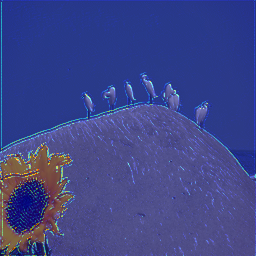

In [15]:
target_layer0 = net.module.transformer.embeddings.constr_conv
print(fmap_out_block[0].shape)
cam_image=grad_cam_fmap_accumlation(rgb_img,fmap_out_block[0],target_layer0)

Image.fromarray(cam_image).save('./visualization/'+filters+'/'+image_name.strip('.jpg')+'_PMSC_gradcam.jpg')
Image.fromarray(cam_image)

In [18]:
print(type(fmap_out_block),len(fmap_out_block[1]),type(fmap_out_block[1][0]))

<class 'list'> 1 <class 'torch.Tensor'>


<class 'torch.Tensor'> 1


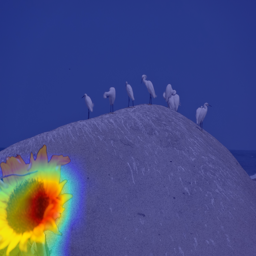

In [16]:
target_layer1 =  net.module.transformer.embeddings.fusion[0]
cam_img=grad_cam_fmap_fusion(rgb_img,fmap_out_block[1],target_layer1)
Image.fromarray(cam_img).save('./visualization/'+filters+'/'+image_name.strip('.jpg')+'_fpn3_gradcam.jpg')
Image.fromarray(cam_img)

<class 'torch.Tensor'> 1


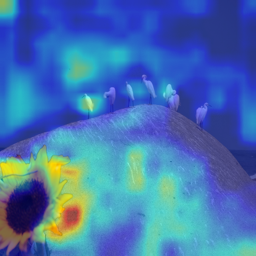

In [17]:
target_layer2 =  net.module.transformer.embeddings.fusion[1],
cam_img=grad_cam_fmap_fusion(rgb_img,fmap_out_block[2],target_layer2[0])
Image.fromarray(cam_img).save('./visualization/'+filters+'/'+image_name.strip('.jpg')+'_fpn2_gradcam.jpg')
Image.fromarray(cam_img)

<class 'torch.Tensor'> 1


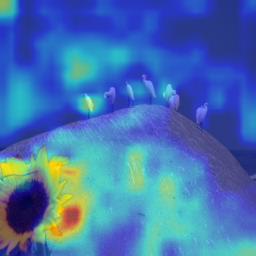

In [18]:
target_layer =  net.module.transformer.embeddings.fusion[2],
cam_img=grad_cam_fmap_fusion(rgb_img,fmap_out_block[3],target_layer2[0])
Image.fromarray(cam_img).save('./visualization/'+filters+'/'+image_name.strip('.jpg')+'_fpn2_gradcam.jpg')
Image.fromarray(cam_img)

<class 'torch.Tensor'> 1


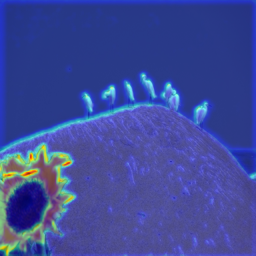

In [19]:
target_layer3 =  net.module.transformer.embeddings.fusion[3]
cam_img=grad_cam_fmap_fusion(rgb_img,fmap_out_block[4],target_layer3)
Image.fromarray(cam_img).save('./visualization/'+filters+'/'+image_name.strip('.jpg')+'_fpn1_gradcam.jpg')
Image.fromarray(cam_img)

<class 'torch.Tensor'> 1


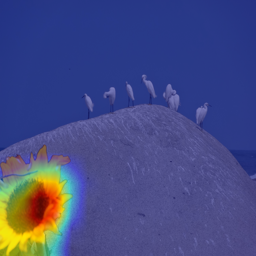

In [20]:
target_layer = net.module.decoder.blocks[0]
cam_img=grad_cam_fmap_fusion(rgb_img,fmap_out_block[5],target_layer1)
Image.fromarray(cam_img).save('./visualization/'+filters+'/'+image_name.strip('.jpg')+'_ECIB1_gradcam.jpg')
Image.fromarray(cam_img)

<class 'torch.Tensor'> 1


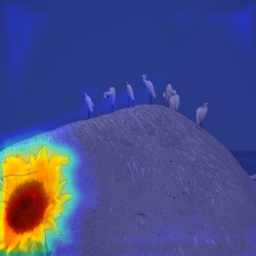

In [21]:
target_layer2 = net.module.decoder.blocks[1]
cam_img=grad_cam_fmap_fusion(rgb_img,fmap_out_block[6],target_layer2)
Image.fromarray(cam_img).save('./visualization/'+filters+'/'+image_name.strip('.jpg')+'_ECIB2_gradcam.jpg')
Image.fromarray(cam_img)

<class 'torch.Tensor'> 1


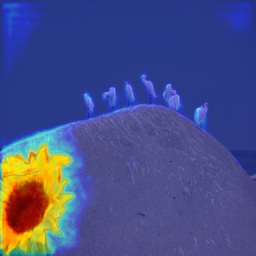

In [22]:
target_layer3 = net.module.decoder.blocks[2]
cam_img=grad_cam_fmap_fusion(rgb_img,fmap_out_block[7],target_layer3)
Image.fromarray(cam_img).save('./visualization/'+filters+'/'+image_name.strip('.jpg')+'_ECIB3_gradcam.jpg')
Image.fromarray(cam_img)

<class 'torch.Tensor'> 1


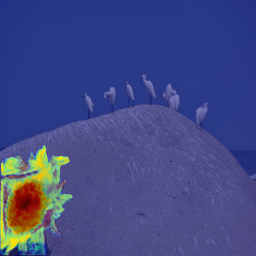

In [23]:
target_layer4 = net.module.decoder.blocks[3]
cam_img=grad_cam_fmap_fusion(rgb_img,fmap_out_block[8],target_layer4)
Image.fromarray(cam_img).save('./visualization/'+filters+'/'+image_name.strip('.jpg')+'_ECIB4_gradcam.jpg')
Image.fromarray(cam_img)

(256, 256, 9)
(256, 256, 9)
(256, 256, 9)


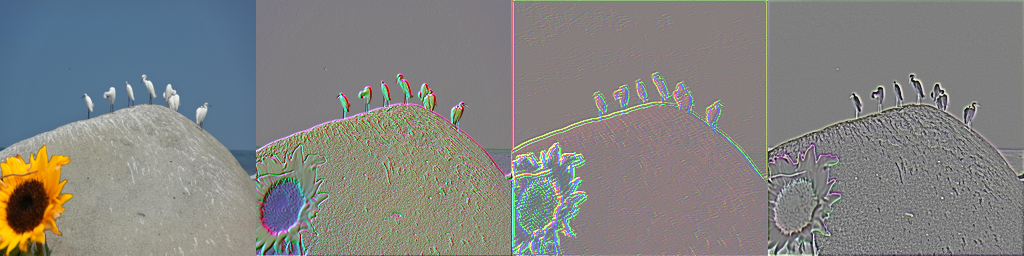

In [27]:
fmap_pmsc = torch.sigmoid(fmap_out_block[0].squeeze()).detach().cpu().numpy()
pmsc_mask=fmap_pmsc.transpose(1,2,0)
pmsc_mask_uint8 =  np.uint8(255 * pmsc_mask)

print(pmsc_mask.shape)
print(pmsc_mask_uint8.shape)

both_images = np.hstack((image, pmsc_mask_uint8[:,:,0:3],pmsc_mask_uint8[:,:,3:6],pmsc_mask_uint8[:,:,6:]))
Image.fromarray(both_images).save('./visualization/'+filters+'/'+image_name.strip('.jpg')+'_PMSC_feature.jpg')
#Image.fromarray(both_images)
Image.fromarray(both_images)


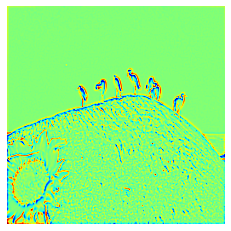

NameError: name 'pmcs_split' is not defined

In [30]:
filters='pmsc'
fmap = fmap_out_block[0].squeeze().detach().cpu().numpy()
pmsc_clip = np.uint8(fmap.transpose(1,2,0))

for i in range(pmsc_clip.shape[2]):
    pmsc_channel_uint8 =  Image.fromarray(255 * pmsc_clip[i]).convert('L')
    pmsc_channel_uint8.save('./visualization/'+filters+'/'+image_name.strip('.jpg')+'_PMSC_channel{}_feature.jpg'.format(i))
    pmsc_split=pmsc_mask[:,:,i-1]
    plt.imshow(pmsc_split-np.mean(pmsc_split), cmap= 'jet')#feature_map[0].shape=torch.Size([55, 55])
    plt.axis('off')
    fig=plt.gcf()
    plt.margins(0,0)
    fig.savefig('./visualization/'+filters+'/'+image_name.strip('.jpg')+'_channel'+str(i)+'_fmap.png')
    plt.show()
    img=Image.fromarray(np.uint8(np.repeat(255*pmsc_split[:, :, None], 3, axis=-1)))
    img.save('./visualization/'+filters+'/'+image_name.strip('.jpg')+'_channel'+str(i)+'_fmap.jpg')

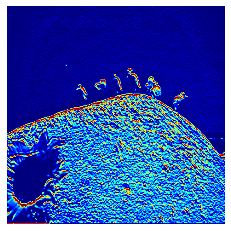

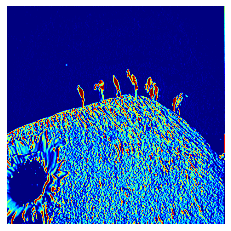

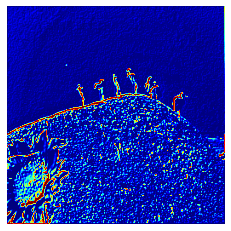

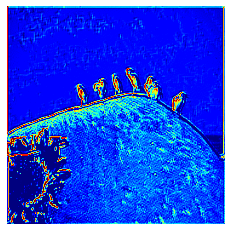

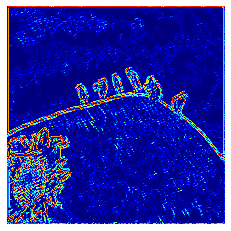

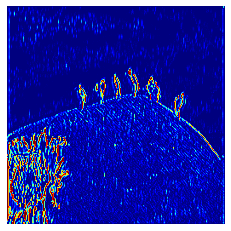

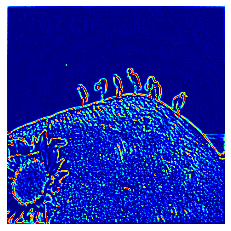

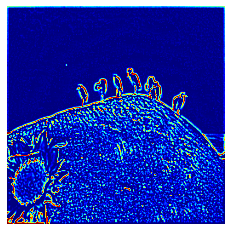

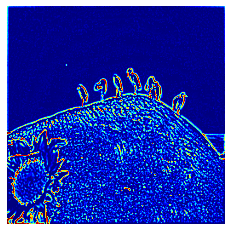

TypeError: Invalid shape (256, 256, 9) for image data

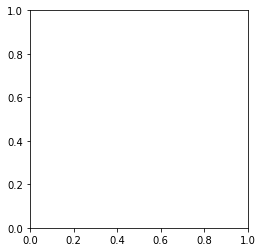

In [28]:
#显示每个channel的feature map
feature_map_num = cshc_mask_uint8.shape[2]#返回通道数
row_num = np.ceil(np.sqrt(feature_map_num))#8
for index in range(1,feature_map_num+1):
    plt.imshow(cshc_clip[:,:,index-1], cmap= 'jet')#feature_map[0].shape=torch.Size([55, 55])
    plt.axis('off')
    fig=plt.gcf()
    plt.margins(0,0)
    fig.savefig('./visualization/'+filters+'/'+image_name.strip('.jpg')+'_channel'+str(index-1)+'_fmap_clip.jpg')
    plt.show()
plt.imshow(cshc_clip, cmap='jet')
out_combine=Image.fromarray(np.uint8(cshc_clip))
out_combine.save('./visualization/'+filters+'/'+image_name.strip('.jpg')+'_fmap_clip.jpg')


In [29]:
def srmConstraint():
    srm1 = torch.zeros(25).reshape(5,5).float()
    srm1[1:-1,1:-1] = torch.tensor(np.array([[-1,-2,-1],[2,-4, 2],[-1,-2,-1]]))
    srm1 /= 4
    #print(srm1)
    srm2 = torch.tensor(np.array([[-1,2,-2,2,-1],[2,-6,8,-6,2],[-2,8,-12,8,-2],[-1,2,-2,2,-1],[2,-6,8,-6,2]])).float()
    srm2 /= 12
    srm3 = torch.zeros(25).reshape(5,5).float()
    srm3[2,1:4] = torch.tensor(np.array([[1,-2,1]])).float()
    srm3 /= 2
    kernel = torch.cat([srm1.unsqueeze(0),srm2.unsqueeze(0),srm3.unsqueeze(0)],axis=0)
    srm_kernel = torch.zeros((3,3,5,5)).float()
    for ch in range(3):
        srm_kernel[ch,...,...,...] = kernel
    #print('kernel:',kernel,kernel.shape)
    #print('srm_kernel:',srm_kernel,srm_kernel.shape)        
    return srm_kernel
kernel=srmConstraint().cuda()
out_srm = torch.nn.functional.conv2d(input_tensor, kernel, stride=1, padding=2)
print(out_srm.shape)

torch.Size([1, 3, 256, 256])


In [30]:
class CWHPF_Conv2d(nn.Module):
    def __init__(self, kernel_size=5, stride=1, padding=2):  
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding 
        super(CWHPF_Conv2d, self).__init__()   
        self.srm_kernel = self.srmConstraint() 
        #self.conv1x1 = nn.Conv2d(in_channels=self.out_channels,out_channels=3, kernel_size=1, stride=1, padding=0)
    
    def srmConstraint(self):
        srm1 = torch.zeros(25).reshape(5,5).float()
        srm1[1:-1,1:-1] = torch.tensor(np.array([[-1,-2,-1],[2,-4, 2],[-1,-2,-1]]))
        srm1 /= 4
        #print(srm1)
        srm2 = torch.tensor(np.array([[-1,2,-2,2,-1],[2,-6,8,-6,2],[-2,8,-12,8,-2],[-1,2,-2,2,-1],[2,-6,8,-6,2]])).float()
        srm2 /= 12
        srm3 = torch.zeros(25).reshape(5,5).float()
        srm3[2,1:4] = torch.tensor(np.array([[1,-2,1]])).float()
        srm3 /= 2
        kernel = torch.cat([srm1.unsqueeze(0),srm2.unsqueeze(0),srm3.unsqueeze(0)],axis=0).unsqueeze(1)
        print('kernel:',kernel,kernel.shape)
       # print('srm_kernel:',srm_kernel,srm_kernel.shape)        
        return kernel  

    def forward(self, x):
        #print('x1:',x.shape)
        r,g,b = torch.chunk(x,3,dim =1)
        x_r = F.conv2d(r, self.srm_kernel.cuda(), stride=self.stride, padding=self.padding)
        x_g = F.conv2d(g, self.srm_kernel.cuda(), stride=self.stride, padding=self.padding)
        x_b = F.conv2d(b, self.srm_kernel.cuda(), stride=self.stride, padding=self.padding)
        #print('xrgb:',x_r.shape,x_g.shape,x_b.shape)
        x = torch.cat((x_r,x_g,x_b),dim=1)
        return x



In [31]:
#load image
image_name = 'NC2016_0942.jpg'
image_path ="./visualization/NC2016_0942.jpg"
image = Image.open(image_path).resize((256,256))
rgb_img = np.float32(np.array(image)) / 255
input_tensor = preprocess_image(rgb_img,
                                mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])
input_tensor = input_tensor.cuda()

label = Image.open(image_path.replace('jpg','png')).resize((256,256))
#label = Image.open(image_path.replace('.tif','_gt.png')).resize((256,256))
label =  np.float32(np.array(label)) / 255
label = torch.from_numpy(label).cuda()
print(input_tensor.shape)
print(label.shape)


torch.Size([1, 3, 256, 256])
torch.Size([256, 256])


In [32]:
net = CWHPF_Conv2d().cuda()
print(net)
out_srm = net(input_tensor)
print(out_srm.shape)


kernel: tensor([[[[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000, -0.2500, -0.5000, -0.2500,  0.0000],
          [ 0.0000,  0.5000, -1.0000,  0.5000,  0.0000],
          [ 0.0000, -0.2500, -0.5000, -0.2500,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000]]],


        [[[-0.0833,  0.1667, -0.1667,  0.1667, -0.0833],
          [ 0.1667, -0.5000,  0.6667, -0.5000,  0.1667],
          [-0.1667,  0.6667, -1.0000,  0.6667, -0.1667],
          [-0.0833,  0.1667, -0.1667,  0.1667, -0.0833],
          [ 0.1667, -0.5000,  0.6667, -0.5000,  0.1667]]],


        [[[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.5000, -1.0000,  0.5000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000]]]]) torch.Size([3, 1, 5, 5])
CWHPF_Conv2d()
torch.Size([1, 9, 256, 256])


In [33]:
fmap_srm = torch.sigmoid(out_srm.squeeze()).detach().cpu().numpy()
#print(fmap_cshc,fmap_cshc.shape)
srm_mask=fmap_srm.transpose(1,2,0)
srm_mask_uint8 = np.uint8(255 *srm_mask)
srm_mask_float = np.float32(srm_mask)
print(srm_mask.shape)
print(srm_mask_uint8.shape)

fmap_clip = out_srm.squeeze().detach().cpu().numpy()
srm_clip = np.clip(fmap_clip,0,1).transpose(1,2,0)
print(srm_clip.shape)

(256, 256, 9)
(256, 256, 9)
(256, 256, 9)


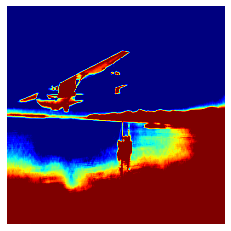

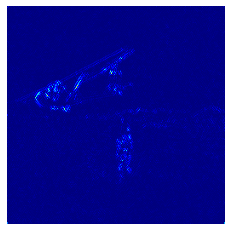

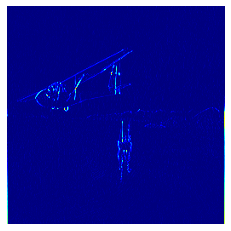

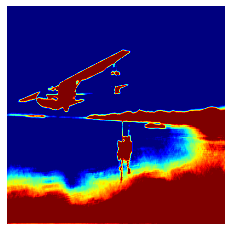

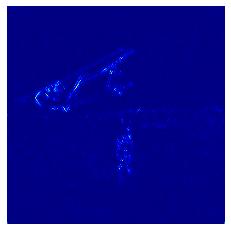

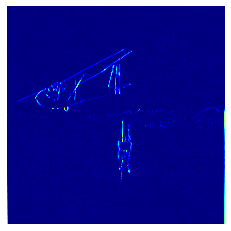

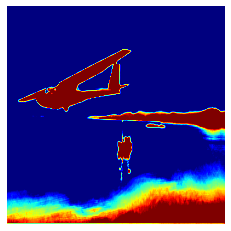

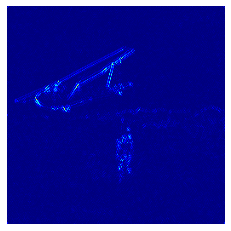

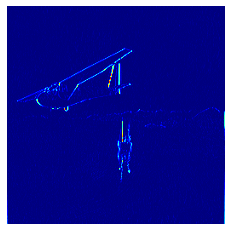

In [34]:
feature_map_num = srm_mask.shape[2]
for index in range(1,feature_map_num+1):
    srm_split=srm_clip[:,:,index-1]
    plt.imshow(srm_split, cmap= 'jet')#feature_map[0].shape=torch.Size([55, 55])
    plt.axis('off')
    fig=plt.gcf()
    plt.margins(0,0)
    fig.savefig('./visualization/srm/'+image_name.strip('.jpg')+'_channel'+str(index-1)+'_fmap.png')
    plt.show()
    img=Image.fromarray(np.uint8(np.repeat(255*srm_split[:, :, None], 3, axis=-1)))
    img.save('./visualization/bayar/'+image_name.strip('.jpg')+'_channel'+str(index-1)+'_fmap.jpg')

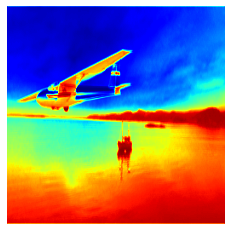

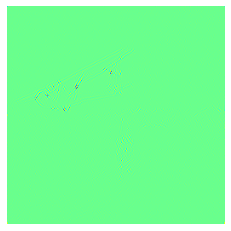

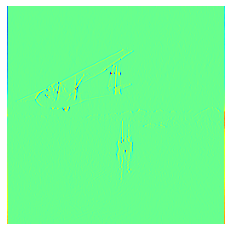

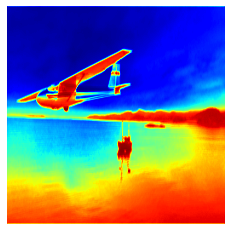

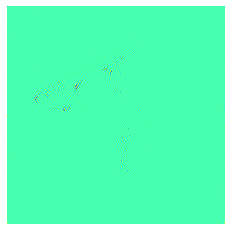

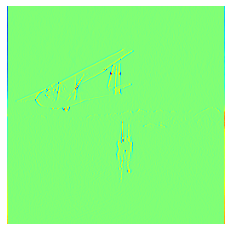

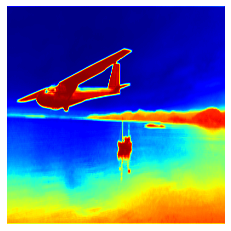

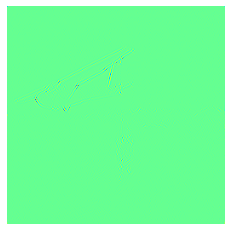

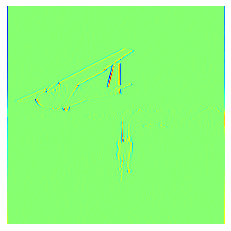

TypeError: Invalid shape (256, 256, 9) for image data

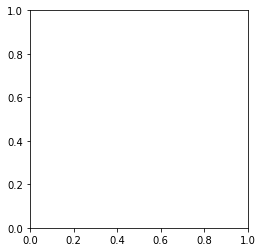

In [35]:
feature_map_num = srm_mask_uint8.shape[2]#返回通道数
#row_num = np.ceil(np.sqrt(feature_map_num))#8
for index in range(1,feature_map_num+1):
    srm_split=srm_mask[:,:,index-1]
    plt.imshow(srm_split, cmap= 'jet')#feature_map[0].shape=torch.Size([55, 55])
    plt.axis('off')
    fig=plt.gcf()
    plt.margins(0,0)
    fig.savefig('./visualization/srm/'+image_name.strip('.jpg')+'_channel'+str(index-1)+'_fmap.png')
    plt.show()
    img=Image.fromarray(np.uint8(np.repeat(255*srm_split[:, :, None], 3, axis=-1)))
    img.save('./visualization/bayar/'+image_name.strip('.jpg')+'_channel'+str(index-1)+'_fmap.jpg')
plt.imshow(srm_mask, cmap='hot')
out_combine=Image.fromarray(np.uint8(255*srm_mask))
out_combine.save('./visualization/srm/'+image_name.strip('.jpg')+'_fmap.jpg')
plt.axis('off')
plt.show()
plt.imshow(image, cmap='jet')
plt.axis('off')
plt.show()

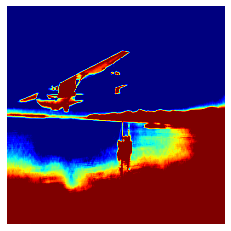

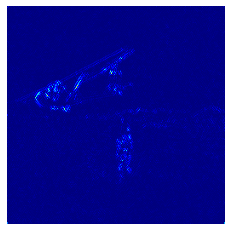

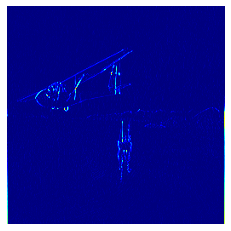

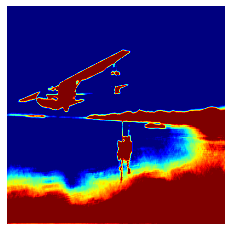

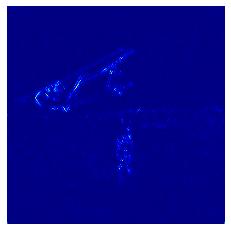

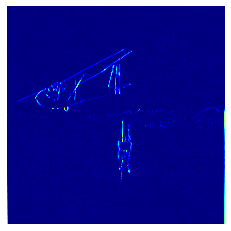

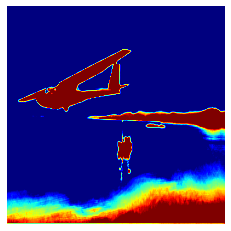

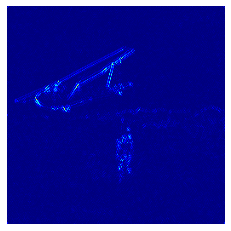

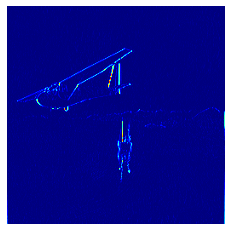

TypeError: Invalid shape (256, 256, 9) for image data

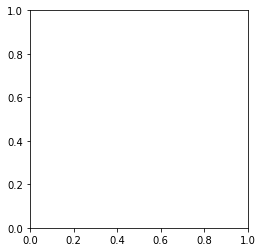

In [36]:
feature_map_num = srm_clip.shape[2]#返回通道数
#row_num = np.ceil(np.sqrt(feature_map_num))#8
for index in range(1,feature_map_num+1):
    srm_split=srm_clip[:,:,index-1]
    plt.imshow(srm_split, cmap= 'jet')#feature_map[0].shape=torch.Size([55, 55])
    plt.axis('off')
    fig=plt.gcf()
    plt.margins(0,0)
    fig.savefig('./visualization/srm/'+image_name.strip('.jpg')+'channel'+str(index-1)+'_fmap.png')
    plt.show()
    img=Image.fromarray(np.uint8(np.repeat(255*srm_split[:, :, None], 3, axis=-1)))
    img.save('./visualization/bayar/'+image_name.strip('.jpg')+'channel'+str(index-1)+'_fmap.jpg')
plt.imshow(srm_clip, cmap='jet')
out_combine=Image.fromarray(np.uint8(srm_clip))
out_combine.save('./visualization/srm/'+image_name.strip('.jpg')+'_fmap.jpg')
plt.axis('off')
plt.show()
plt.imshow(image, cmap='jet')
plt.axis('off')
plt.show()

In [37]:
#显示每个channel的feature map
fmap_num = ecib_clip.shape[2]#返回通道数
#row_num = np.ceil(np.sqrt(feature_map_num))#8
ecib_fuse1 = np.zeros((ecib_mask.shape[0],ecib_mask.shape[1]))
print(ecib_fuse1.shape)
for index in range(1,fmap_num+1):
    #ecib_split = cv.resize(ecib_mask[:,:,index-1],(256,256),cv.INTER_LINEAR)
    ecib_split=ecib_mask[:,:,index-1]
    print(ecib_split.shape)
    ecib_fuse1 += ecib_split
    plt.imshow(ecib_split, cmap= 'jet')#feature_map[0].shape=torch.Size([55, 55])
    plt.axis('off')
    fig=plt.gcf()
    plt.margins(0,0)
    fig.savefig('./visualization/'+image_name+'ecib_outmap'+str(index-1)+'.png')
    plt.show()
plt.imshow(ecib_fuse1/fmap_num, cmap='jet')
out_combine=Image.fromarray(np.uint8(np.repeat(ecib_fuse1[:, :, None], 3, axis=-1)))
out_combine.save('./visualization/'+image_name+'ecib_outmap.png')
plt.axis('off')
plt.show()
plt.imshow(image, cmap='jet')
plt.axis('off')
plt.show()

NameError: name 'ecib_clip' is not defined

## Wait, the model output is a dictionary, it's not a Tensor!

This package assumes the model will output a tensor.
Here, instead, it's returning a dictionarty with the "out" and "aux" keys, where the actual result we care about is in "out".
This is a common issue with custom networks, sometimes the model outputs a tuple, for example, and maybe you care only about one of it's outputs.

To solve this we're going to wrap the model first.

In [4]:
class SegmentationModelOutputWrapper(torch.nn.Module):
    def __init__(self, model): 
        super(SegmentationModelOutputWrapper, self).__init__()
        self.model = model
        
    def forward(self, x):
        return self.model(x)["out"]
    
model = SegmentationModelOutputWrapper(model)
output = model(input_tensor)
print(output.shape)


torch.Size([1, 21, 375, 500])


Now, lets run the model on the image, and show which pixels are predicted as belonging to the car mask.

7
(375, 500)


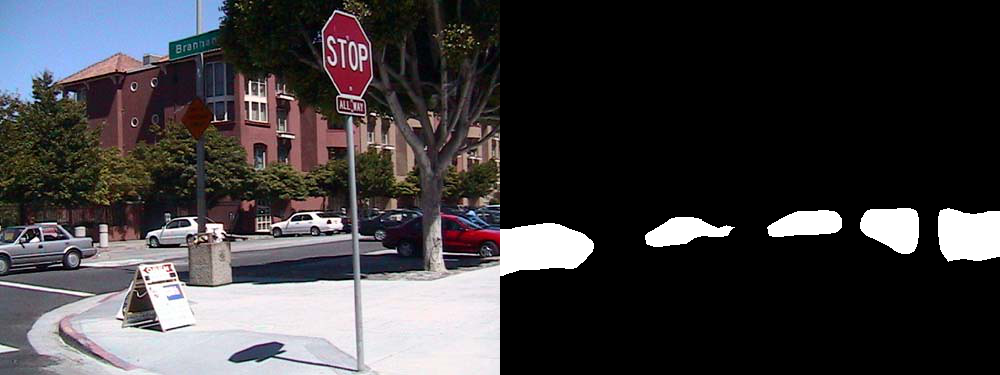

In [6]:
normalized_masks = torch.nn.functional.softmax(output, dim=1).cpu()
sem_classes = [
    '__background__', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'
]
sem_class_to_idx = {cls: idx for (idx, cls) in enumerate(sem_classes)}

car_category = sem_class_to_idx["car"]
print(car_category)
car_mask = normalized_masks[0, :, :, :].argmax(axis=0).detach().cpu().numpy()
car_mask_uint8 = 255 * np.uint8(car_mask == car_category)
car_mask_float = np.float32(car_mask == car_category)
print(car_mask_float.shape)

both_images = np.hstack((image, np.repeat(car_mask_uint8[:, :, None], 3, axis=-1)))
Image.fromarray(both_images)

To apply a class activation method here, we need to decide about a few things:
    - What layer (or layers) are we going to work with?
    - What's going to be the target we want to maximize?

We're going to chose backbone.layer4 as an arbitrary choice that can be tuned.
You can print(model) and see which other layers you might want to try.

As for the target, we're going to take all the pixels that belong to the "car" category, and sum their predictions.

[Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(1024, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(1024, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): Bottleneck(
    (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

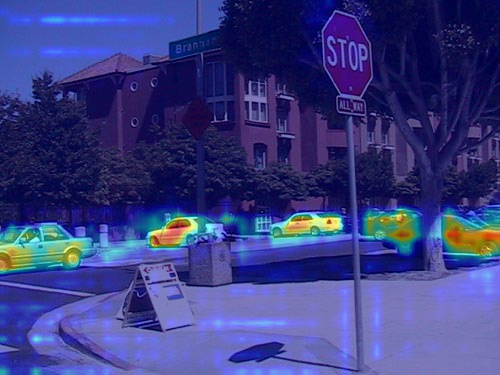

In [13]:
from pytorch_grad_cam import GradCAM

class SemanticSegmentationTarget:
    def __init__(self, category, mask):
        self.category = category
        print(self.category)
        self.mask = torch.from_numpy(mask)
        if torch.cuda.is_available():
            self.mask = self.mask.cuda()
        
    def __call__(self, model_output):
        print('model_out:',model_output.shape)
        return (model_output[self.category, :, : ] * self.mask).sum()

    
target_layers = [model.model.backbone.layer4]
print(target_layers)
targets = [SemanticSegmentationTarget(car_category, car_mask_float)]
print(type(targets),len(targets),targets[0])
with GradCAM(model=model,
             target_layers=target_layers,
             use_cuda=torch.cuda.is_available()) as cam:
    grayscale_cam = cam(input_tensor=input_tensor,
                        targets=targets)[0, :]
    cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

Image.fromarray(cam_image)
    

Notice how we're getting pixels outside the otirinal masks as well. This is because every pixel is affected by it's sourrounding pixels as well.

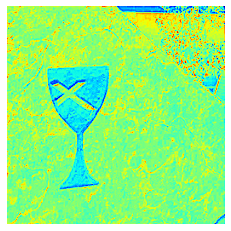

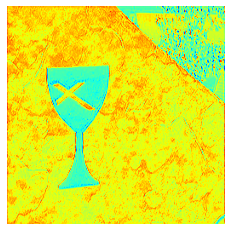

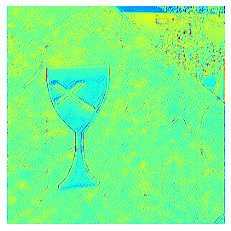

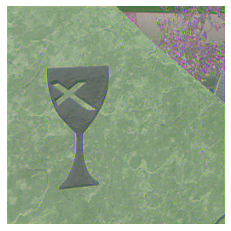

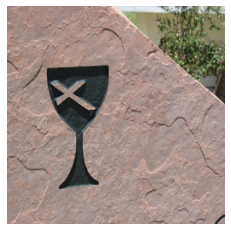

In [15]:
feature_map_num = cshc_mask_uint8.shape[2]#返回通道数
#plt.figure(figsize=(256, 256))
#plt.figure()
row_num = np.ceil(np.sqrt(feature_map_num))#8
for index in range(1,feature_map_num+1):
    #plt.subplot(row_num, 3, index)
    plt.imshow(cshc_mask_uint8[:,:,index-1], cmap= 'jet')#feature_map[0].shape=torch.Size([55, 55])
    plt.axis('off')
    #plt.colorbar()# 显示色度条
    fig=plt.gcf()
    plt.margins(0,0)
    fig.savefig('outmap'+str(index-1)+'.png')
    plt.show()
    #out=Image.fromarray(tamper_mask_uint8[:,:,index-1])
    #out.save('outmap'+str(index-1)+'.png')
       
#plt.subplot(row_num, 3, index+1)
plt.imshow(cshc_mask_uint8, cmap='jet')
out_combine=Image.fromarray(cshc_mask_uint8)
out_combine.save('outmap.png')
#plt.colorbar()# 显示色度条
plt.axis('off')
#plt.subplot(row_num, 3, index+2)
plt.show()
plt.imshow(image, cmap='jet')
#plt.colorbar()# 显示色度条
plt.axis('off')
#scipy.misc.imsave( 'feature_map_save//'+str(index) + ".png", feature_map[index - 1])
plt.show()